# Introduction

The following uses sklearn's MLP artificial network classifier to fit a classifier that distinguishes between a pair of sketch categories from the Quick, Draw! dataset from Google:

https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1

Categories were chosen below to make a somewhat difficult comparison (two objects that typically look alike)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier

from utilities import computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

# Settings

In [3]:
# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional size of test dataset
testSize = 1/5.

# Number of folds for GridSearchCV
nfolds = 5

# Settings to control which features are used
pRows = 28
pCols = 28
pColNames = list(range(pRows * pCols))
pScale = 255.0 # Scale factor for pixels.  Pixel raw data is 0 to 255.  Set to 1 to avoid scaling

# Number of samples PER CATEGORY (defined below)
nSamples = 7500

# Names of all models to include
# names = ['baseball', 'basketball', 'camel', 'cow', 'clock', 'wristwatch']
names = ['baseball', 'basketball']

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

# Maximum iterations for iterative classification trainers
maxIter = 1000

# Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(10, 1000, 5).round(), np.array([2000, 4000, 6000, 9000])]).astype('int')

In [4]:
# Used for plot names
est = "quickdraw_mlp"
scoreText = "Score (Classification Accuracy)"

# Load Data

In [5]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 7500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 7500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [6]:
# Create X, y, XTest, yTest using just the features we care about...

XFull = data.loc[:, pColNames].values
print(f'XFull.shape = {XFull.shape}')
yFull = data.loc[:, 'classNumber'].values
print(f'yFull.shape = {yFull.shape}')

X, XTest, y, yTest = train_test_split(XFull, yFull, test_size=testSize, 
                                      random_state=randomSeed, stratify=yFull)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be 0.5)')

XFull.shape = (15000, 784)
yFull.shape = (15000,)

X.shape = (12000, 784)
y.shape = (12000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

XTest.shape = (3000, 784)
yTest.shape = (3000,)
Ratio of yTest=1 to yTest=0 for Test data: 0.5 (should be 0.5)


# Initial Parameter Setting using GridSearchCV with Nominal Data Set

Examine the hyperparameter space using GridSearchCV.

In [7]:
hidden_layer_sizes = ((2, ), (4, ), (6, ), (10, ), (2, 2), (10, 2))
alphas =  [0.0001, 0.00031, 0.001]
paramGrid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'alpha': alphas,
}

nData = 2000
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(MLPClassifier(activation='logistic', max_iter=maxIter, random_state=randomSeed), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 2000 data samples
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:  6.3min remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.6min finished


In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,13.430287,7.413797,0.002993,0.001092,0.0001,"(2,)","{'alpha': 0.0001, 'hidden_layer_sizes': (2,)}",0.785536,0.7500,0.7800,...,0.7590,0.027624,8,0.893684,0.920000,0.920000,0.928750,0.794503,0.891387,0.049850
1,30.048465,16.200298,0.003591,0.000798,0.0001,"(4,)","{'alpha': 0.0001, 'hidden_layer_sizes': (4,)}",0.775561,0.7425,0.7675,...,0.7495,0.021423,14,0.992495,0.965000,0.936250,0.985625,0.770768,0.930028,0.081998
2,40.140880,18.110424,0.003392,0.000489,0.0001,"(6,)","{'alpha': 0.0001, 'hidden_layer_sizes': (6,)}",0.780549,0.7625,0.7800,...,0.7700,0.021662,1,0.983114,0.983750,0.979375,0.986875,0.798876,0.946398,0.073800
3,39.927252,16.772587,0.003591,0.000489,0.0001,"(10,)","{'alpha': 0.0001, 'hidden_layer_sizes': (10,)}",0.733167,0.7325,0.7500,...,0.7365,0.011185,17,0.996248,0.996250,0.994375,0.994375,0.817614,0.959772,0.071084
4,28.775268,8.647585,0.003592,0.000799,0.0001,"(2, 2)","{'alpha': 0.0001, 'hidden_layer_sizes': (2, 2)}",0.773067,0.7525,0.7625,...,0.7595,0.010014,7,0.923077,0.903125,0.926250,0.919375,0.840100,0.902385,0.032144
5,38.418287,20.798067,0.005186,0.001934,0.0001,"(10, 2)","{'alpha': 0.0001, 'hidden_layer_sizes': (10, 2)}",0.755611,0.7675,0.7600,...,0.7590,0.007316,8,0.984991,0.990000,0.911250,0.987500,0.843223,0.943393,0.058164
6,20.040022,8.036006,0.003791,0.000747,0.00031,"(2,)","{'alpha': 0.00031, 'hidden_layer_sizes': (2,)}",0.785536,0.7500,0.7800,...,0.7590,0.027624,8,0.893684,0.920000,0.920000,0.928750,0.794503,0.891387,0.049850
7,31.788412,17.130106,0.003791,0.000399,0.00031,"(4,)","{'alpha': 0.00031, 'hidden_layer_sizes': (4,)}",0.775561,0.7425,0.7675,...,0.7495,0.021423,14,0.992495,0.965000,0.935625,0.985625,0.770768,0.929903,0.081989
8,40.545002,18.156820,0.003192,0.000399,0.00031,"(6,)","{'alpha': 0.00031, 'hidden_layer_sizes': (6,)}",0.780549,0.7600,0.7800,...,0.7700,0.021001,1,0.983114,0.983750,0.979375,0.986875,0.798876,0.946398,0.073800
9,41.240542,17.435959,0.003790,0.000746,0.00031,"(10,)","{'alpha': 0.00031, 'hidden_layer_sizes': (10,)}",0.733167,0.7275,0.7500,...,0.7360,0.012252,18,0.995622,0.996250,0.994375,0.994375,0.816989,0.959522,0.071270


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d90870ceb8>)

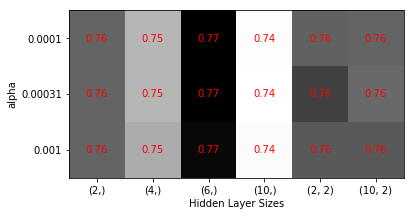

In [10]:
toPlot = np.zeros((len(alphas), len(hidden_layer_sizes)))
for i, hls in enumerate(alphas):
    for j, a in enumerate(hidden_layer_sizes):
        k = i * len(hidden_layer_sizes) + j
        toPlot[i, j] = gs.cv_results_['mean_test_score'][k]
heatmap(toPlot, hidden_layer_sizes, alphas, xlabel='Hidden Layer Sizes', ylabel='alpha', 
        savefig=est + pltNameSuffix + "_gs")

In [11]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for computing the learning curve:
{'alpha': 0.0001, 'hidden_layer_sizes': (6,)}
This model has score of 0.77 in cross validation for grid search and 0.7356666666666667 on the held-out test data


# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

In [12]:
lc_params = copy.deepcopy(gs.best_params_)

lcNameBase = est + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(MLPClassifier(activation='logistic', max_iter=maxIter, random_state=randomSeed, **lc_params), X, y, testSize = testSize,
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                         randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'alpha': 0.0001, 'hidden_layer_sizes': (6,)}
Over 9 folds: [  10   32  100  316 1000 2000 4000 6000 9000]
Indices included at fold 0: 10
	Model trained in 0.39s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.40s
Indices included at fold 1: 32
	Model trained in 0.42s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.43s
Indices included at fold 2: 100
	Model trained in 0.57s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.58s
Indices included at fold 3: 316
	Model trained in 2.24s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 2.25s
Indices included at fold 4: 1000
	Model trained in 7.49s
	Model Scored on Training Data in 0.01s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 7.51s

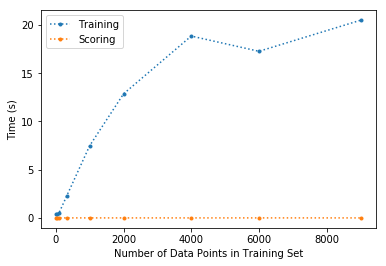

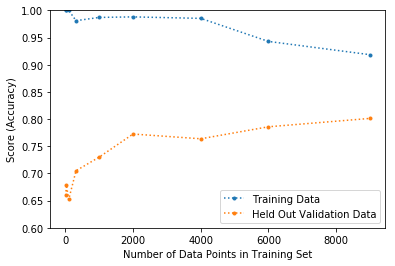

No handles with labels found to put in legend.


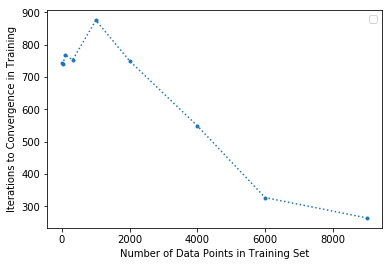

In [13]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, bottom=accuracyMin, top=accuracyMax, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

plotIterationCurve(lc, savefig = lcNameBase + "_iteration")

In [14]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.801 achieved with 9000 samples


# Refit Model on Best Data

Refit the model using a second GridSearchCV search for hyperparameters, then score the model on the held out test data. 

In [15]:
hidden_layer_sizes = ((2, ), (4, ), (6, ), (10, ), (2, 2), (10, 2))
alphas = [0.0001,]
paramGrid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'alpha': alphas, 
}

nData = bestData
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(MLPClassifier(activation='logistic', random_state=randomSeed, max_iter=maxIter), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [16]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)
pltNameSuffix = '_final'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 9000 data samples
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  3.4min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  4.4min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  4.7min remaining:   31.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.4min finished


In [17]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,47.282388,7.029802,0.013963,0.008053,0.0001,"(2,)","{'alpha': 0.0001, 'hidden_layer_sizes': (2,)}",0.804553,0.779012,0.775556,...,0.787444,0.012016,2,0.855813,0.861647,0.859861,0.816414,0.824052,0.843558,0.019290
1,47.087110,22.553643,0.011768,0.004779,0.0001,"(4,)","{'alpha': 0.0001, 'hidden_layer_sizes': (4,)}",0.809550,0.786785,0.787778,...,0.790111,0.010900,1,0.874149,0.890263,0.864444,0.795028,0.828774,0.850532,0.034304
2,80.692465,54.675485,0.013963,0.009031,0.0001,"(6,)","{'alpha': 0.0001, 'hidden_layer_sizes': (6,)}",0.785675,0.770128,0.770556,...,0.777444,0.007629,6,0.942075,0.941242,0.956111,0.795862,0.797806,0.886619,0.073502
3,116.105188,70.908216,0.010772,0.001163,0.0001,"(10,)","{'alpha': 0.0001, 'hidden_layer_sizes': (10,)}",0.790117,0.765130,0.775000,...,0.783333,0.012813,5,0.981386,0.974858,0.982917,0.811554,0.841411,0.918425,0.075711
4,60.880235,14.789294,0.008577,0.000797,0.0001,"(2, 2)","{'alpha': 0.0001, 'hidden_layer_sizes': (2, 2)}",0.804553,0.774570,0.769444,...,0.784444,0.015312,4,0.885401,0.883595,0.888056,0.825858,0.828357,0.862253,0.028742
5,84.401349,30.628757,0.008178,0.002630,0.0001,"(10, 2)","{'alpha': 0.0001, 'hidden_layer_sizes': (10, 2)}",0.781788,0.774570,0.757222,...,0.785444,0.021041,3,0.987082,0.986665,0.990278,0.858631,0.885710,0.941673,0.057405


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d9089b9a20>)

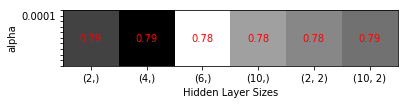

In [18]:
toPlot = np.zeros((len(alphas), len(hidden_layer_sizes)))
for i, hls in enumerate(alphas):
    for j, a in enumerate(hidden_layer_sizes):
        k = i * len(hidden_layer_sizes) + j
        toPlot[i, j] = gs.cv_results_['mean_test_score'][k]
heatmap(toPlot, hidden_layer_sizes, alphas, xlabel='Hidden Layer Sizes', ylabel='alpha',
        savefig=est + pltNameSuffix + "_gs")

In [19]:
print(f'From this, we choose the following parameters for the final model:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for the final model:
{'alpha': 0.0001, 'hidden_layer_sizes': (4,)}
This model has score of 0.7901111111111111 in cross validation for grid search and 0.7783333333333333 on the held-out test data


# Confusion Matrix

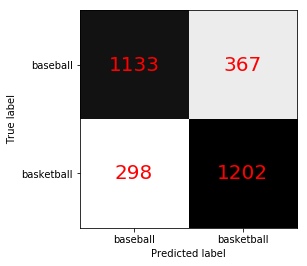

In [20]:
predictions = gs.predict(XTest)
ax = plotConfusionMatrix(yTest, predictions, names, savefig=est + pltNameSuffix + "_confusion")

# Examples of Incorrect Classifications

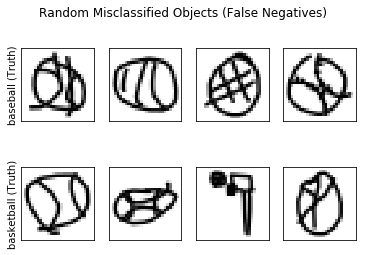

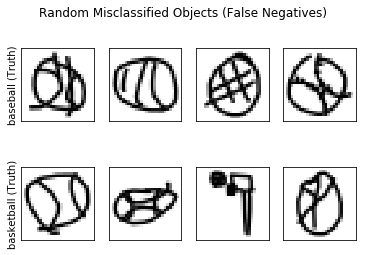

In [21]:
classNumbers = [nameDict[name] for name in names]
drawIncorrectSketches(XTest, yTest, predictions, classNumbers=[0, 1], names=names, n=4, randomSeed=randomSeed, savefig=est + pltNameSuffix + "_Misclassified")